# SSY340 Project - Trajectory Estimation LSTM

### Fill in group number and member names:

In [1]:
NAME1 = "Bingcheng Chen" 
NAME2 = "Arvin Rokni"
GROUP = "Project groups 64"

## 1. Loading the data

In [2]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import os
import dataloader
import model_LSTM
import utils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## 2. Pre-processing

In [3]:
# defining model save location
save_location = "./LSTM_models"
# defining dataset locations
dataset_folder = "./datasets"
dataset_name = "raw"
# setting validation size. if val_size = 0, split percentage is 80-20
val_size = 0
# length of sequence given to encoder
gt = 8
# length of sequence given to decoder
horizon = 12


train_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size,
                                             gt, horizon, delim="\t", train=True)
val_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size,
                                           gt, horizon, delim="\t", train=False)
# test_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size, \
#     gt, horizon, delim="\t", train=False, eval=True)

In [4]:
val_dataset[10]

{'src': tensor([[ 4.9693e+00,  8.3395e+00,  0.0000e+00,  0.0000e+00],
         [ 5.1330e+00,  8.3350e+00,  1.6374e-01, -4.5338e-03],
         [ 5.2968e+00,  8.3307e+00,  1.6374e-01, -4.2963e-03],
         [ 5.3915e+00,  8.3490e+00,  9.4709e-02,  1.8377e-02],
         [ 5.4565e+00,  8.3774e+00,  6.5034e-02,  2.8400e-02],
         [ 5.5218e+00,  8.4058e+00,  6.5244e-02,  2.8400e-02],
         [ 5.5868e+00,  8.4342e+00,  6.5033e-02,  2.8400e-02],
         [ 5.5988e+00,  8.4497e+00,  1.1997e-02,  1.5512e-02]]),
 'trg': tensor([[ 5.5575e+00,  8.4521e+00, -4.1251e-02,  2.3870e-03],
         [ 5.5163e+00,  8.4548e+00, -4.1251e-02,  2.6255e-03],
         [ 5.4750e+00,  8.4571e+00, -4.1251e-02,  2.3861e-03],
         [ 5.4340e+00,  8.4595e+00, -4.1041e-02,  2.3870e-03],
         [ 5.3927e+00,  8.4622e+00, -4.1251e-02,  2.6245e-03],
         [ 5.3515e+00,  8.4645e+00, -4.1251e-02,  2.3870e-03],
         [ 5.3102e+00,  8.4669e+00, -4.1251e-02,  2.3861e-03],
         [ 5.2690e+00,  8.4696e+00, -4.

In [5]:
val_dataset[10]['src'].shape

torch.Size([8, 4])

## 3. Data loaders

In [6]:
# defining batch size
batch_size = 64

# creating torch dataloaders
train_loader = DataLoader(train_dataset, batch_size,
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=0)

## 4. Training

#### 4.1 create a model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LSTM_model = model_LSTM.LSTM(input_size=2, input_seq_len=8,
                             hidden_size=128, num_layers=3, output_size=2, output_seq_len=12).to(device)

In [8]:
LSTM_model

LSTM(
  (LSTM_first_layer): ModuleList(
    (0): LSTMCell(
      (W_hh): Linear(in_features=128, out_features=512, bias=True)
      (W_xh): Linear(in_features=2, out_features=512, bias=True)
    )
    (1-2): 2 x LSTMCell(
      (W_hh): Linear(in_features=128, out_features=512, bias=True)
      (W_xh): Linear(in_features=128, out_features=512, bias=True)
    )
  )
  (LSTM_whole): ModuleList(
    (0): LSTMCell(
      (W_hh): Linear(in_features=128, out_features=512, bias=True)
      (W_xh): Linear(in_features=2, out_features=512, bias=True)
    )
    (1-2): 2 x LSTMCell(
      (W_hh): Linear(in_features=128, out_features=512, bias=True)
      (W_xh): Linear(in_features=128, out_features=512, bias=True)
    )
  )
  (fc): Linear(in_features=1024, out_features=24, bias=True)
)

#### 4.2 The training loop

In [9]:
# number of epochs
epochs = 100

# metric variables
training_loss = []
validation_loss = []
val_mad = []
val_fad = []

# Define the MSE loss function
criterion = nn.MSELoss()

learning_rate = 0.0001
# optimizer = torch.optim.SGD(LSTM_model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=learning_rate)
# optimizer = torch.optim.AdamW(LSTM_model.parameters(), lr=1e-2, betas=(0.9, 0.95), weight_decay=1e-1)


for epoch in tqdm(range(epochs)):
    # TRAINING MODE
    LSTM_model.train()

    # training batch variables
    train_batch_loss = 0

    for idx, data in enumerate(train_loader):
        # getting encoder input data
        X = data['src'][:, :, 0:2].to(device)
        target = data['trg'][:, :, 0:2].to(device)

        # forward pass
        optimizer.zero_grad()
        # predictions = tf_model.forward(enc_input, dec_input, dec_source_mask, dec_target_mask)
        predictions = LSTM_model.forward(X)

        loss = criterion(predictions.view(X.size(0), -1),
                         target.contiguous().view(X.size(0), -1))
        train_batch_loss += loss.item()

        # updating weights
        loss.backward()
        optimizer.step()

    training_loss.append(train_batch_loss/len(train_loader))
    print("Epoch {}/{}....Training loss = {:.4f}".format(epoch +
                                                         1, epochs, training_loss[-1]))

    # validation loop
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            # EVALUATION MODE
            LSTM_model.eval()

            # validation variables
            batch_val_loss = 0
            gt = []
            pr = []

            for id_b, data in enumerate(val_loader):
                # storing groung truth
                truth = data['trg'][:, :, 0:2].to(device)
                gt.append(data['trg'][:, :, 0:2])
                # input to encoder input
                val_input = data['src'][:, :, 0:2].to(device)
                # prediction till horizon lenght
                model_output = LSTM_model.forward(val_input)
                pr.append(model_output.view(val_input.size(0), 12, -1).cpu())

                # calculating loss using pairwise distance of all predictions
                val_loss = criterion(model_output.view(val_input.size(
                    0), -1), truth.contiguous().view(val_input.size(0), -1))
                batch_val_loss += val_loss.item()

            validation_loss.append(batch_val_loss/len(val_loader))

            # calculating mad and fad evaluation metrics
            gt = np.concatenate(gt, 0)
            pr = np.concatenate(pr, 0)
            mad, fad, _ = dataloader.distance_metrics(gt, pr)
            val_mad.append(mad)
            val_fad.append(fad)

            print("Epoch {}/{}....Validation mad = {:.4f}, Validation fad = {:.4f}".format(
                epoch+1, epochs, mad, fad))

    # Saving model, loss and error log files
    torch.save({
        'model_state_dict': LSTM_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_loss': training_loss,
        'validation_loss': validation_loss,
        'val_mad': val_mad,
        'val_fad': val_fad,
        'learning_rate': learning_rate
    }, os.path.join(save_location, 'LSTM_epoch{}.pth'.format(epoch+1)))


  1%|██                                                                                                                                                                                                          | 1/100 [00:09<15:08,  9.18s/it]

Epoch 1/100....Training loss = 15.2918


  2%|████                                                                                                                                                                                                        | 2/100 [00:17<14:12,  8.70s/it]

Epoch 2/100....Training loss = 5.5651


  3%|██████                                                                                                                                                                                                      | 3/100 [00:26<13:53,  8.59s/it]

Epoch 3/100....Training loss = 2.0455


  4%|████████▏                                                                                                                                                                                                   | 4/100 [00:34<13:39,  8.54s/it]

Epoch 4/100....Training loss = 1.1318
Epoch 5/100....Training loss = 0.8608


  5%|██████████▏                                                                                                                                                                                                 | 5/100 [00:43<14:03,  8.88s/it]

Epoch 5/100....Validation mad = 0.8968, Validation fad = 1.4893


  6%|████████████▏                                                                                                                                                                                               | 6/100 [00:52<13:36,  8.69s/it]

Epoch 6/100....Training loss = 0.7227


  7%|██████████████▎                                                                                                                                                                                             | 7/100 [01:00<13:19,  8.60s/it]

Epoch 7/100....Training loss = 0.6533


  8%|████████████████▎                                                                                                                                                                                           | 8/100 [01:09<13:03,  8.52s/it]

Epoch 8/100....Training loss = 0.5970


  9%|██████████████████▎                                                                                                                                                                                         | 9/100 [01:17<12:49,  8.45s/it]

Epoch 9/100....Training loss = 0.5538
Epoch 10/100....Training loss = 0.5213


 10%|████████████████████▎                                                                                                                                                                                      | 10/100 [01:26<13:01,  8.69s/it]

Epoch 10/100....Validation mad = 0.7397, Validation fad = 1.2682


 11%|██████████████████████▎                                                                                                                                                                                    | 11/100 [01:34<12:43,  8.58s/it]

Epoch 11/100....Training loss = 0.4925


 12%|████████████████████████▎                                                                                                                                                                                  | 12/100 [01:43<12:27,  8.49s/it]

Epoch 12/100....Training loss = 0.4675


 13%|██████████████████████████▍                                                                                                                                                                                | 13/100 [01:51<12:12,  8.42s/it]

Epoch 13/100....Training loss = 0.4464


 14%|████████████████████████████▍                                                                                                                                                                              | 14/100 [01:59<11:58,  8.36s/it]

Epoch 14/100....Training loss = 0.4285
Epoch 15/100....Training loss = 0.4115


 15%|██████████████████████████████▍                                                                                                                                                                            | 15/100 [02:09<12:16,  8.67s/it]

Epoch 15/100....Validation mad = 0.6846, Validation fad = 1.2015


 16%|████████████████████████████████▍                                                                                                                                                                          | 16/100 [02:17<11:57,  8.54s/it]

Epoch 16/100....Training loss = 0.3987


 17%|██████████████████████████████████▌                                                                                                                                                                        | 17/100 [02:25<11:43,  8.47s/it]

Epoch 17/100....Training loss = 0.3796


 18%|████████████████████████████████████▌                                                                                                                                                                      | 18/100 [02:33<11:31,  8.43s/it]

Epoch 18/100....Training loss = 0.3707


 19%|██████████████████████████████████████▌                                                                                                                                                                    | 19/100 [02:42<11:23,  8.44s/it]

Epoch 19/100....Training loss = 0.3604
Epoch 20/100....Training loss = 0.3520


 20%|████████████████████████████████████████▌                                                                                                                                                                  | 20/100 [02:51<11:33,  8.67s/it]

Epoch 20/100....Validation mad = 0.6058, Validation fad = 1.1057


 21%|██████████████████████████████████████████▋                                                                                                                                                                | 21/100 [02:59<11:14,  8.54s/it]

Epoch 21/100....Training loss = 0.3455


 22%|████████████████████████████████████████████▋                                                                                                                                                              | 22/100 [03:08<11:00,  8.47s/it]

Epoch 22/100....Training loss = 0.3356


 23%|██████████████████████████████████████████████▋                                                                                                                                                            | 23/100 [03:16<10:46,  8.39s/it]

Epoch 23/100....Training loss = 0.3304


 24%|████████████████████████████████████████████████▋                                                                                                                                                          | 24/100 [03:24<10:34,  8.35s/it]

Epoch 24/100....Training loss = 0.3239
Epoch 25/100....Training loss = 0.3158


 25%|██████████████████████████████████████████████████▊                                                                                                                                                        | 25/100 [03:33<10:48,  8.64s/it]

Epoch 25/100....Validation mad = 0.5606, Validation fad = 1.0921


 26%|████████████████████████████████████████████████████▊                                                                                                                                                      | 26/100 [03:42<10:38,  8.62s/it]

Epoch 26/100....Training loss = 0.3111


 27%|██████████████████████████████████████████████████████▊                                                                                                                                                    | 27/100 [03:50<10:23,  8.55s/it]

Epoch 27/100....Training loss = 0.3056


 28%|████████████████████████████████████████████████████████▊                                                                                                                                                  | 28/100 [03:59<10:09,  8.46s/it]

Epoch 28/100....Training loss = 0.3039


 29%|██████████████████████████████████████████████████████████▊                                                                                                                                                | 29/100 [04:07<09:57,  8.41s/it]

Epoch 29/100....Training loss = 0.2985
Epoch 30/100....Training loss = 0.2925


 30%|████████████████████████████████████████████████████████████▉                                                                                                                                              | 30/100 [04:16<10:08,  8.70s/it]

Epoch 30/100....Validation mad = 0.5032, Validation fad = 1.0080


 31%|██████████████████████████████████████████████████████████████▉                                                                                                                                            | 31/100 [04:25<09:52,  8.58s/it]

Epoch 31/100....Training loss = 0.2906


 32%|████████████████████████████████████████████████████████████████▉                                                                                                                                          | 32/100 [04:33<09:37,  8.49s/it]

Epoch 32/100....Training loss = 0.2883


 33%|██████████████████████████████████████████████████████████████████▉                                                                                                                                        | 33/100 [04:41<09:30,  8.52s/it]

Epoch 33/100....Training loss = 0.2866


 34%|█████████████████████████████████████████████████████████████████████                                                                                                                                      | 34/100 [04:50<09:18,  8.46s/it]

Epoch 34/100....Training loss = 0.2848
Epoch 35/100....Training loss = 0.2799


 35%|███████████████████████████████████████████████████████████████████████                                                                                                                                    | 35/100 [04:59<09:21,  8.63s/it]

Epoch 35/100....Validation mad = 0.5089, Validation fad = 1.0114


 36%|█████████████████████████████████████████████████████████████████████████                                                                                                                                  | 36/100 [05:07<09:06,  8.54s/it]

Epoch 36/100....Training loss = 0.2756


 37%|███████████████████████████████████████████████████████████████████████████                                                                                                                                | 37/100 [05:15<08:52,  8.46s/it]

Epoch 37/100....Training loss = 0.2762


 38%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 38/100 [05:24<08:40,  8.39s/it]

Epoch 38/100....Training loss = 0.2730


 39%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 39/100 [05:32<08:27,  8.33s/it]

Epoch 39/100....Training loss = 0.2719
Epoch 40/100....Training loss = 0.2704


 40%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 40/100 [05:41<08:36,  8.61s/it]

Epoch 40/100....Validation mad = 0.5096, Validation fad = 1.0099


 41%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 41/100 [05:49<08:20,  8.49s/it]

Epoch 41/100....Training loss = 0.2686


 42%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 42/100 [05:57<08:07,  8.40s/it]

Epoch 42/100....Training loss = 0.2706


 43%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 43/100 [06:06<07:57,  8.37s/it]

Epoch 43/100....Training loss = 0.2662


 44%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 44/100 [06:14<07:46,  8.33s/it]

Epoch 44/100....Training loss = 0.2660
Epoch 45/100....Training loss = 0.2653


 45%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 45/100 [06:23<07:54,  8.62s/it]

Epoch 45/100....Validation mad = 0.5668, Validation fad = 1.0614


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 46/100 [06:32<07:39,  8.50s/it]

Epoch 46/100....Training loss = 0.2610


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 47/100 [06:40<07:27,  8.44s/it]

Epoch 47/100....Training loss = 0.2616


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 48/100 [06:48<07:15,  8.37s/it]

Epoch 48/100....Training loss = 0.2629


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 49/100 [06:56<07:03,  8.30s/it]

Epoch 49/100....Training loss = 0.2571
Epoch 50/100....Training loss = 0.2582


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 50/100 [07:05<07:07,  8.55s/it]

Epoch 50/100....Validation mad = 0.5084, Validation fad = 0.9971


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 51/100 [07:13<06:52,  8.41s/it]

Epoch 51/100....Training loss = 0.2576


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 52/100 [07:22<06:39,  8.33s/it]

Epoch 52/100....Training loss = 0.2558


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 53/100 [07:30<06:28,  8.27s/it]

Epoch 53/100....Training loss = 0.2539


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 54/100 [07:38<06:18,  8.23s/it]

Epoch 54/100....Training loss = 0.2570
Epoch 55/100....Training loss = 0.2558


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 55/100 [07:47<06:26,  8.58s/it]

Epoch 55/100....Validation mad = 0.4950, Validation fad = 0.9866


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 56/100 [07:55<06:12,  8.46s/it]

Epoch 56/100....Training loss = 0.2517


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 57/100 [08:04<06:00,  8.38s/it]

Epoch 57/100....Training loss = 0.2520


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 58/100 [08:12<05:49,  8.32s/it]

Epoch 58/100....Training loss = 0.2505


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 59/100 [08:20<05:38,  8.25s/it]

Epoch 59/100....Training loss = 0.2490
Epoch 60/100....Training loss = 0.2504


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 60/100 [08:29<05:40,  8.50s/it]

Epoch 60/100....Validation mad = 0.4685, Validation fad = 0.9639


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 61/100 [08:37<05:27,  8.40s/it]

Epoch 61/100....Training loss = 0.2499


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 62/100 [08:46<05:20,  8.42s/it]

Epoch 62/100....Training loss = 0.2496


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 63/100 [08:54<05:08,  8.34s/it]

Epoch 63/100....Training loss = 0.2474


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 64/100 [09:02<04:58,  8.29s/it]

Epoch 64/100....Training loss = 0.2477
Epoch 65/100....Training loss = 0.2465


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 65/100 [09:11<04:59,  8.57s/it]

Epoch 65/100....Validation mad = 0.4702, Validation fad = 0.9526


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 66/100 [09:19<04:47,  8.45s/it]

Epoch 66/100....Training loss = 0.2464


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 67/100 [09:27<04:36,  8.38s/it]

Epoch 67/100....Training loss = 0.2466


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 68/100 [09:36<04:26,  8.31s/it]

Epoch 68/100....Training loss = 0.2445


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 69/100 [09:44<04:17,  8.30s/it]

Epoch 69/100....Training loss = 0.2433
Epoch 70/100....Training loss = 0.2436


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 70/100 [09:53<04:16,  8.56s/it]

Epoch 70/100....Validation mad = 0.4710, Validation fad = 0.9697


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 71/100 [10:01<04:05,  8.46s/it]

Epoch 71/100....Training loss = 0.2420


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 72/100 [10:10<03:55,  8.40s/it]

Epoch 72/100....Training loss = 0.2423


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 73/100 [10:18<03:44,  8.33s/it]

Epoch 73/100....Training loss = 0.2417


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 74/100 [10:26<03:35,  8.28s/it]

Epoch 74/100....Training loss = 0.2417
Epoch 75/100....Training loss = 0.2389


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 75/100 [10:35<03:33,  8.55s/it]

Epoch 75/100....Validation mad = 0.4918, Validation fad = 0.9646


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 76/100 [10:44<03:24,  8.53s/it]

Epoch 76/100....Training loss = 0.2405


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 77/100 [10:52<03:13,  8.43s/it]

Epoch 77/100....Training loss = 0.2407


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 78/100 [11:00<03:03,  8.34s/it]

Epoch 78/100....Training loss = 0.2405


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 79/100 [11:08<02:54,  8.29s/it]

Epoch 79/100....Training loss = 0.2376
Epoch 80/100....Training loss = 0.2383


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 80/100 [11:17<02:50,  8.53s/it]

Epoch 80/100....Validation mad = 0.5124, Validation fad = 1.0113


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 81/100 [11:25<02:40,  8.44s/it]

Epoch 81/100....Training loss = 0.2360


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 82/100 [11:34<02:30,  8.34s/it]

Epoch 82/100....Training loss = 0.2370


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 83/100 [11:42<02:21,  8.32s/it]

Epoch 83/100....Training loss = 0.2353


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 84/100 [11:50<02:12,  8.27s/it]

Epoch 84/100....Training loss = 0.2366
Epoch 85/100....Training loss = 0.2354


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 85/100 [11:59<02:07,  8.53s/it]

Epoch 85/100....Validation mad = 0.4837, Validation fad = 0.9730


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 86/100 [12:07<01:57,  8.42s/it]

Epoch 86/100....Training loss = 0.2324


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 87/100 [12:15<01:48,  8.34s/it]

Epoch 87/100....Training loss = 0.2331


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 88/100 [12:24<01:39,  8.29s/it]

Epoch 88/100....Training loss = 0.2324


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 89/100 [12:32<01:30,  8.24s/it]

Epoch 89/100....Training loss = 0.2319
Epoch 90/100....Training loss = 0.2310


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 90/100 [12:41<01:25,  8.54s/it]

Epoch 90/100....Validation mad = 0.4743, Validation fad = 0.9683


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 91/100 [12:49<01:15,  8.41s/it]

Epoch 91/100....Training loss = 0.2308


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 92/100 [12:57<01:06,  8.35s/it]

Epoch 92/100....Training loss = 0.2304


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 93/100 [13:05<00:58,  8.29s/it]

Epoch 93/100....Training loss = 0.2291


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 94/100 [13:14<00:49,  8.27s/it]

Epoch 94/100....Training loss = 0.2293
Epoch 95/100....Training loss = 0.2296


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 95/100 [13:23<00:42,  8.55s/it]

Epoch 95/100....Validation mad = 0.4863, Validation fad = 0.9868


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 96/100 [13:31<00:33,  8.42s/it]

Epoch 96/100....Training loss = 0.2297


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 97/100 [13:39<00:25,  8.37s/it]

Epoch 97/100....Training loss = 0.2280


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 98/100 [13:48<00:16,  8.38s/it]

Epoch 98/100....Training loss = 0.2269


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 99/100 [13:56<00:08,  8.30s/it]

Epoch 99/100....Training loss = 0.2281
Epoch 100/100....Training loss = 0.2264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:05<00:00,  8.45s/it]

Epoch 100/100....Validation mad = 0.4898, Validation fad = 0.9728


## 5. Visualisation

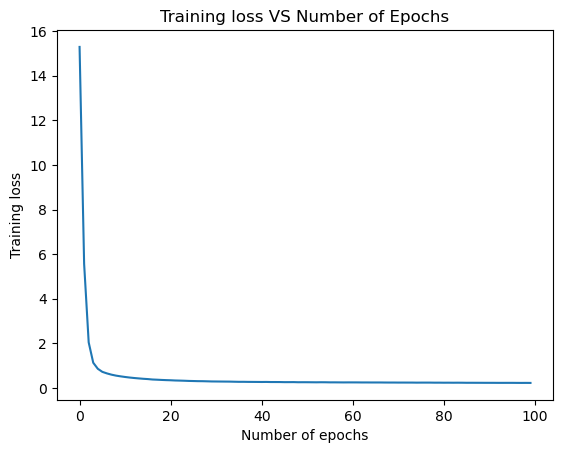

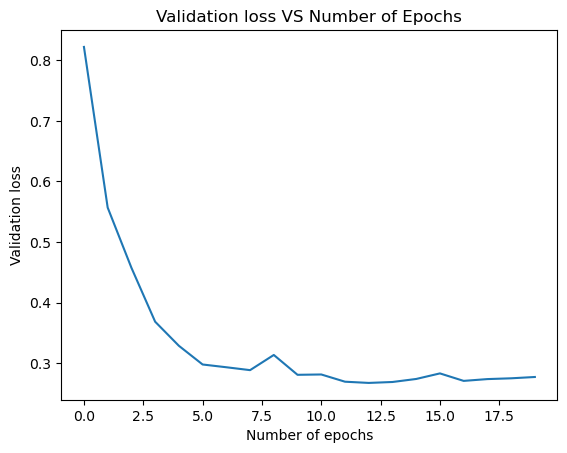

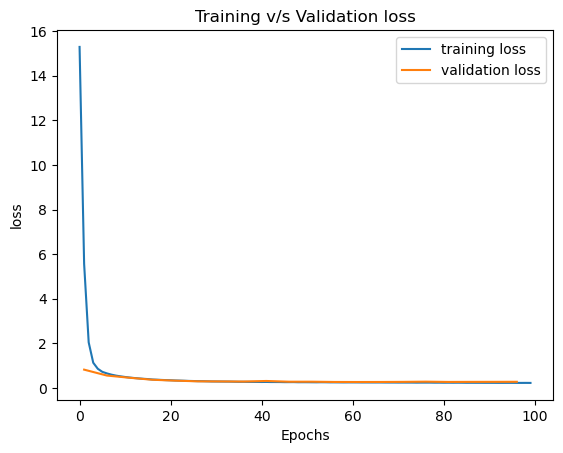

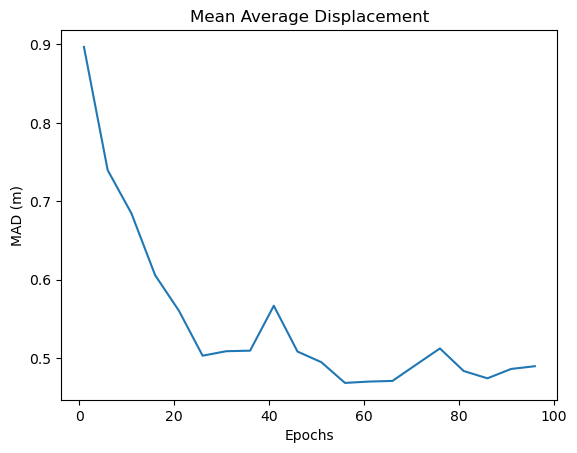

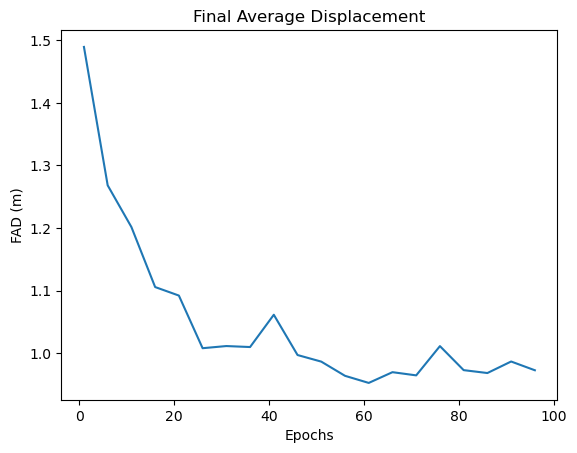

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_file = torch.load(os.path.join(
    save_location, 'LSTM_epoch100.pth'), map_location=torch.device(device))

# creating model and loading weights
# encoder_ip_size = 2
# decoder_ip_size = 3
# model_op_size = 3
# emb_size = 512
# num_heads = 8
# ff_hidden_size = 2048
# n = 6
# dropout = 0.1

# model_loaded = model.TFModel(encoder_ip_size, decoder_ip_size, model_op_size, emb_size,
#                              num_heads, ff_hidden_size, n, dropout=0.1)

model_loaded = model_LSTM.LSTM(input_size=2, input_seq_len=8,
                             hidden_size=128, num_layers=3, output_size=2, output_seq_len=12).to(device)


model_loaded = model_loaded.to(device)
model_loaded.load_state_dict(loaded_file['model_state_dict'])

# loading training metric variables
training_loss = loaded_file['training_loss']
validation_loss = loaded_file['validation_loss']
val_mad = loaded_file['val_mad']
val_fad = loaded_file['val_fad']
learning_rate = loaded_file['learning_rate']

# plotting training loss
plt.figure()
plt.plot(training_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.title("Training loss VS Number of Epochs")

# plotting validation loss
plt.figure()
plt.plot(validation_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Validation loss")
plt.title("Validation loss VS Number of Epochs")

# plotting training and validation loss together
plt.figure()
plt.plot(loaded_file['training_loss'], label="training loss")
plt.plot(np.arange(1, 100, 5),
            loaded_file['validation_loss'], label="validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Training v/s Validation loss")
plt.savefig("loss.png")

# plotting learning rate for model
# plt.figure()
# plt.plot(learning_rate)
# plt.xlabel("Number of epochs")
# plt.ylabel("learning_rate")
# plt.title("Learning_rate VS Number of Epochs")

# plotting MAD
plt.figure()
plt.plot(np.arange(1, 100, 5),
            loaded_file['val_mad'], label="validation MAD")
plt.xlabel("Epochs")
plt.ylabel("MAD (m)")
plt.title("Mean Average Displacement")
plt.savefig("mad.png")

# plotting FAD
plt.figure()
plt.plot(np.arange(1, 100, 5),
            loaded_file['val_fad'], label="validation FAD")
plt.xlabel("Epochs")
plt.ylabel("FAD (m)")
plt.title("Final Average Displacement")
plt.savefig("fad.png")

plt.show()

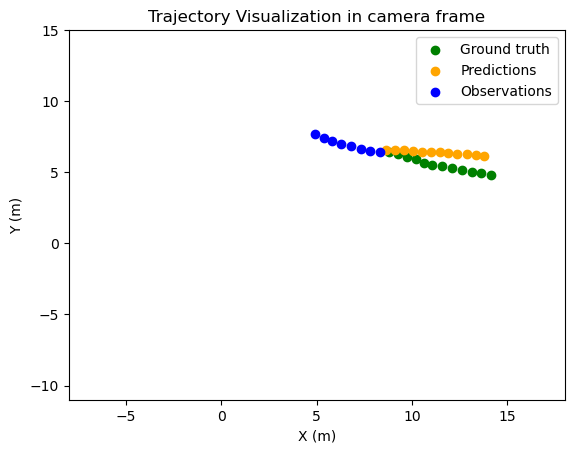

In [12]:
# Running the validation loop to generate prediction trajectories on validation data
validation_loss = []
val_mad = []
val_fad = []

with torch.no_grad():
    # EVALUATION MODE
    model_loaded.eval()

    # validation variables
    batch_val_loss = 0
    gt = []
    pr = []
    obs = []

    for id_b, data in enumerate(val_loader):
        # storing groung truth
        truth = data['trg'][:, :, 0:2].to(device)
        gt.append(data['trg'][:, :, 0:2])
        obs.append(data['src'][:, :, 0:2])
        # input to encoder input
        val_input = data['src'][:, :, 0:2].to(device)

        # prediction till horizon lenght
        model_output = model_loaded.forward(val_input)
        pr.append(model_output.view(val_input.size(0), 12, -1).cpu())

        # calculating loss using pairwise distance of all predictions
        val_loss = criterion(model_output.view(val_input.size(0), -1), truth.contiguous().view(val_input.size(0), -1))
        batch_val_loss += val_loss.item()

        validation_loss.append(batch_val_loss/len(val_loader))

    # calculating mad and fad evaluation metrics
    gt = np.concatenate(gt, 0)
    pr = np.concatenate(pr, 0)
    obs = np.concatenate(obs, 0)
    mad, fad, _ = dataloader.distance_metrics(gt, pr)
    val_mad.append(mad)
    val_fad.append(fad)

# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.savefig("traj_{}".format(idx))

plt.show()

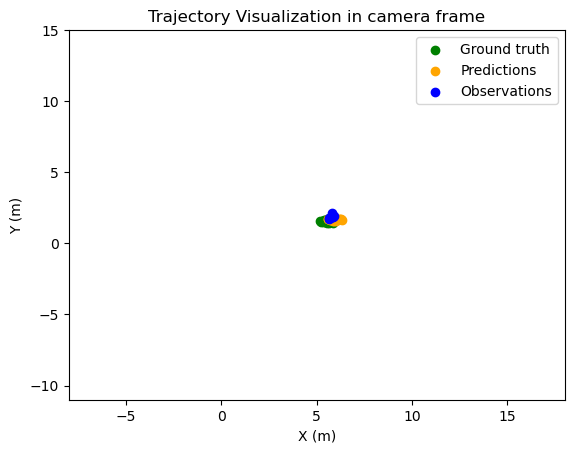

In [13]:
# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
# plt.savefig("traj_{}".format(idx))

plt.show()

## 6. Evaluation on test set